In [86]:
import re
import json
import nltk
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from tqdm import tqdm
import spacy
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from nltk.stem import PorterStemmer
from sklearn.decomposition import PCA
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mathiaskroismoller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mathiaskroismoller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# NPL
In this section we have attempted to process the summaries in a way that could cluster the movies depending on words used in the summaries themself. 
Some of the processes take a long time to run so in the code there are multiple data sets or lists being saved as files to avoid running computational heavy tasks multiple times. 

In [87]:
# CHECK BEFORE RUNNING!!!
flag_preprocess = False # If false, skip the generation of a preprocessed corpus
flag_cluster_labels_kmeans = False # Run the kmeans algorithm and return labels for every movie 
flag_movie_cluster = False # If false, stop overwrite of a cluster matrix
flag_best_k = False # Runs a simulation to make silhouettes of a set number of k's for kmeans algorithm 
flag_best_component = False # Runs test to find a lower bound for amount of components

### Load and filter movie data

In [73]:
# Read main data file 'movie_metadata_TMDB.csv'
movie_metadata = pd.read_csv('data/movie_metadata_TMDB.csv')

# Filter rows with no values in the box office and voting columns
movie_metadata_filtered = movie_metadata.dropna(subset=['TMDB_vote_average', 'Movie box office revenue'])

# Extract movie IDs from the filtered DataFrame
movie_ids_filtered = movie_metadata_filtered['Wikipedia Movie ID'].tolist()

# Read file 'plot_summaries.txt'
with open('data/plot_summaries.txt', 'r', encoding='utf-8') as file:
    summaries = file.readlines()

# Filter summaries based on movie IDs that match with filtered_movie_ids
filtered_summaries = [summary for summary in summaries if int(summary.split()[0]) in movie_ids_filtered]

# Extract movie IDs for the films that with be used
movie_ids = [int(summary.split()[0]) for summary in filtered_summaries]

### Preprocess the summaries 

In [45]:
# Preprocess the summaries and stemming
def preprocess_text(text):
    # Remove special characters and digits
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    # Convert to lowercase and tokenize
    words = nltk.word_tokenize(text.lower())
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words('english')]
    # Apply stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

# Remove names form the summaries
nlp = spacy.load("en_core_web_sm")

def remove_names(text): 
    doc = nlp(text)
    filtered_text = []
    for token in doc:
        if token.ent_type_ != "PERSON":
            filtered_text.append(token.text)
    return " ".join(filtered_text)

In [46]:
# Preprocess the summaries 
preprocessed_summaries = []
if flag_preprocess:
    for summary in tqdm(filtered_summaries, desc="Processing summaries"):
        preprocessed_summaries.append(preprocess_text(remove_names(summary.split('\t')[1])))
    
    # Save preprocessed_summaries list to a file
    with open('preprocessed_summaries.pkl', 'wb') as file:
        pickle.dump(preprocessed_summaries, file)

In [47]:
# Combined stemmed summaries with labels 
if flag_preprocess:
    summaries_preprocessed_dist = []
    for i in range(len(preprocessed_summaries)):
        summaries_preprocessed_dist.append({"id": movie_ids[i], "text": preprocessed_summaries[i]})
    
    # Save summaries_preprocessed_dist to a file
    with open('summaries_preprocessed_dist.json', 'w') as f:
        json.dump(summaries_preprocessed_dist, f)

# TF/IDF vectorization & kmeans

In [48]:
# Load preprocessed_summaries list from the saved file
with open('preprocessed_summaries.pkl', 'rb') as file:
    preprocessed_summaries = pickle.load(file)

In [49]:
# Convert text data into numerical features using TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_summaries)


Now we will determine the optimal number of components (n_components) for dimensionality reduction using Truncated Singular Value Decomposition (Truncated SVD) by plotting the explained variance ratio against a range of specified values for n_components and identifying a point where a sufficient amount of variance is retained.

100%|██████████| 3/3 [13:56<00:00, 278.94s/it]


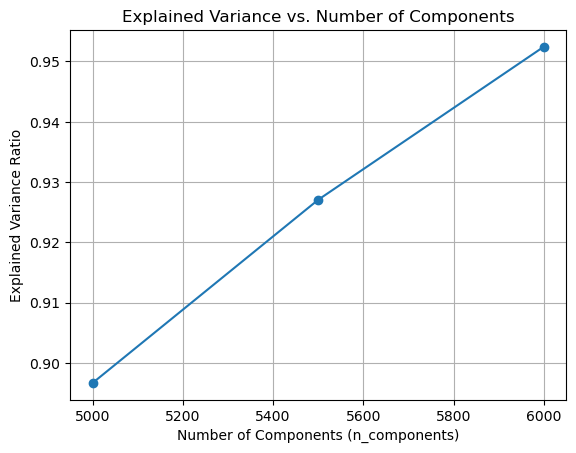

In [617]:
if flag_best_component:  
    # Specify a range of n_components to try
    components_range = np.arange(5000, 6001, 500)
    
    # List to store explained variance ratios
    explained_variances = []
    
    for n_components in tqdm(components_range):
        # Apply Truncated SVD
        svd = TruncatedSVD(n_components=n_components)
        tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)
        
        # Calculate explained variance ratio
        explained_variance = np.sum(svd.explained_variance_ratio_)
        explained_variances.append(explained_variance)
    
    # Plot the explained variance ratio as a function of n_components
    plt.plot(components_range, explained_variances, marker='o')
    plt.title('Explained Variance vs. Number of Components')
    plt.xlabel('Number of Components (n_components)')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

We see that with 6000 components we get above an EVR og 95%.

In [618]:
if flag_best_component:    
    # Apply Truncated SVD for dimensionality reduction
    n_components = 6000  
    svd = TruncatedSVD(n_components=n_components)
    tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

### Finding the optimal k

In [619]:
if flag_best_k:
    silhouettes = []
    sse = []
    # Try multiple k
    for k in tqdm(range(20, 40)):
        # Cluster the data and assigne the labels
        labels = kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(tfidf_matrix_reduced) 
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(tfidf_matrix_reduced) 
        sse.append({"k": k, "sse": kmeans.inertia_})
        # Get the Silhouette score
        score = silhouette_score(tfidf_matrix_reduced, labels)
        silhouettes.append({"k": k, "score": score})

100%|██████████| 20/20 [10:54<00:00, 32.71s/it]


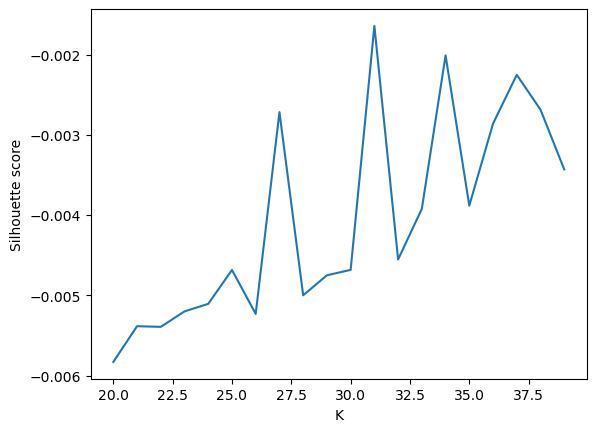

In [620]:
if flag_best_k:   
    # Convert to dataframe
    silhouettes = pd.DataFrame(silhouettes)
    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(silhouettes.k, silhouettes.score)
    plt.xlabel("K")
    plt.ylabel("Silhouette score") 

Negative values... Something is off. We have not been able to identify the problem for now.

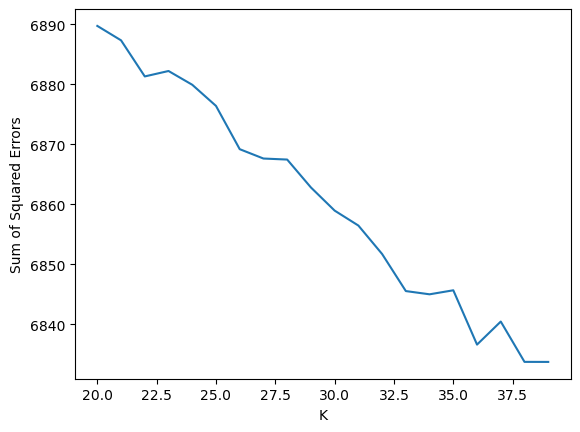

In [640]:
if flag_best_k:
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")

There is no obvious "elbow" to be seen. We choose to go with 30 clusters and see what we get.

### Apply KMeans clustering 

In [622]:
# Apply KMeans clustering and return the labels for every movie 
num_clusters = 30 # k 

if flag_cluster_labels_kmeans: 
    cluster_labels = KMeans(n_clusters=num_clusters, random_state=42, n_init=10).fit_predict(tfidf_matrix_reduced) # This takes quite some time...
    
    # Save cluster_labels to a file
    with open('cluster_labels.pkl', 'wb') as f:
        pickle.dump(cluster_labels, f)


In [72]:
# Load cluster_labels from a file
with open('cluster_labels.pkl', 'rb') as f:
    cluster_labels = pickle.load(f)

In [68]:
# Create a dictionary to store movie IDs and their corresponding cluster labels
movie_clusters_id = dict(zip(movie_ids, cluster_labels))

With the movies given a cluster label we make a dataframe with all the movies in the given dataframe. For easy readability the movie ids are replaced with their actual name. 

In [625]:
# Create a DataFrame to store cluster information
cluster_df = pd.DataFrame(columns=[f'Cluster {i}' for i in range(num_clusters)])

# Iterate through movie clusters and match with movie_metadata_filtered
if flag_movie_cluster:
    for movie_id, cluster_label in tqdm(movie_clusters_id.items()):
        # Find the corresponding row in movie_metadata_filtered based on Wikipedia Movie ID
        movie_row = movie_metadata_filtered[movie_metadata_filtered['Wikipedia Movie ID'] == movie_id]
        
        # Extract movie name from the row
        movie_name = movie_row['Movie name'].values[0] if not movie_row.empty else f'Movie {movie_id}'
        
        # Update cluster_df with movie name in the appropriate cluster column
        cluster_df.loc[len(cluster_df), f'Cluster {cluster_label}'] = movie_name
    
    
    # Fill NaN values with empty string for better representation
    cluster_df.fillna('', inplace=True)

100%|██████████| 7490/7490 [00:09<00:00, 780.32it/s] 


In [3]:
# Save cluster_df as CSV
if flag_movie_cluster:
    cluster_df.to_csv('clustered_movies.csv', index=True)

In [39]:
# Load cluster_df from a file
cluster_df = pd.read_csv('clustered_movies.csv')
cluster_df['Cluster 10'].sort_values().head(10)

4614                   Aliens in the Attic
6381                                Alien³
3593                      Battle for Terra
4816                            Battleship
5468                        Chicken Little
1375    Close Encounters of the Third Kind
4512                    Cocoon: The Return
3954                      Cowboys & Aliens
6292                            District 9
498             E.T. the Extra-Terrestrial
Name: Cluster 10, dtype: object

Looking at the titles in fx Cluster 10 as printed above, it looks as if our method at least clusters movies about similar topics.

# Visualizing word in clusters
In the following segment we try to look at the clusters and see if there seems to be any relevant information to be found in them. 
Firstly we will visualize the clusters in "Word Clouds".

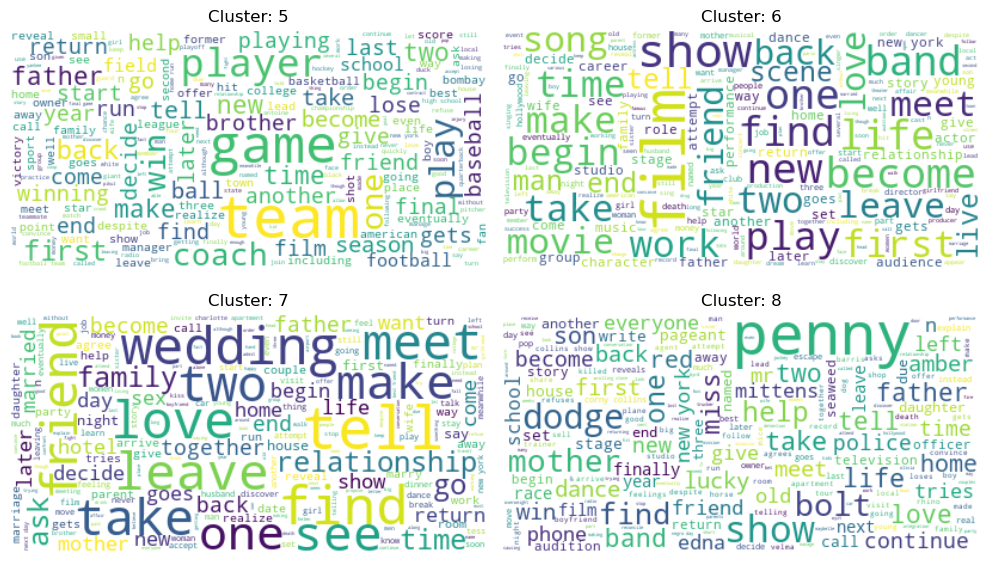

In [628]:
from wordcloud import WordCloud

pic = {'cluster': cluster_labels, 'sum': preprocessed_summaries}
pic = pd.DataFrame(pic)

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for k in range(5,9):
    ax = axes[(k-5) // 2, (k-5) % 2]

    # Extract data for the current cluster
    s = pic[pic.cluster == k]
    text = s['sum'].str.cat(sep=' ')

    # Generate word cloud
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)

    # Plot the word cloud
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title('Cluster: {}'.format(k))
    ax.axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

We see that the 4 cluster seen here have some clear tendencies as well. Looking at Cluster 7 the bigger words, that represent more relevance, seem to fal in the same category with love, wedding, friend and relationship as dominant tokens. 

### Top words in each cluster
Now we will try to sort all the words after importance to the clusters.

In [52]:
def get_top_words_for_clusters(tfidf_matrix, cluster_labels, vectorizer, top_n=10):
    cluster_words = {}
    terms = vectorizer.get_feature_names_out()
    
    for cluster_label in range(max(cluster_labels) + 1):
        cluster_indices = np.where(cluster_labels == cluster_label)[0]
        cluster_tfidf_scores = np.sum(tfidf_matrix[cluster_indices], axis=0)
        sorted_indices = np.argsort(cluster_tfidf_scores)[0, ::-1][:top_n]
        top_words = [terms[i] for i in sorted_indices]
        cluster_words[cluster_label] = top_words
        
    return cluster_words

# Call the function to get cluster words
cluster_words = get_top_words_for_clusters(tfidf_matrix, cluster_labels, vectorizer)

In [53]:
cluster_words[10][0][0][:10]

array(['alien', 'aliens', 'earth', 'ship', 'humans', 'spaceship', 'human',
       'spacecraft', 'creature', 'government'], dtype=object)

We are again looking at Cluster 10. The most relevant words seem to relate a lot to the titles we saw falling into this cluster. Aliens and space are apparently a theme for this cluster. 

In [57]:
# Dataframe for top 1000 words ranked for every cluster
cluster_words_ranked = pd.DataFrame()

for i in range(len(cluster_words)):
    cluster_words_ranked[f'{i}'] = cluster_words[i][0][0][:1000]
    
cluster_words_ranked.head(10)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,robot,one,jake,father,ship,team,film,wedding,penny,children,...,war,mr,sons,ash,girls,fbi,maggie,killer,dr,superman
1,machine,police,alonzo,house,crew,game,show,love,dodge,family,...,army,mrs,family,book,school,agent,henry,sean,buddy,earth
2,robots,life,two,tells,captain,coach,band,hotel,show,house,...,soldiers,house,marion,demon,mother,president,daughter,house,amanda,connor
3,code,new,luck,car,earth,players,new,married,bolt,mother,...,camp,father,daughter,possessed,evie,agents,mother,car,hospital,planet
4,mccandless,two,find,money,planet,football,story,together,amber,kids,...,men,one,writer,demons,party,cia,dutch,police,doctor,lex
5,soul,back,new,police,enterprise,play,life,relationship,barris,father,...,american,back,relationship,exorcism,town,team,son,killed,patient,klaatu
6,time,man,father,home,space,player,music,family,band,home,...,general,boys,film,cabin,get,bomb,time,body,patients,space
7,human,father,pastor,one,aboard,baseball,play,tells,corny,one,...,german,tells,young,pokémon,decide,smith,one,find,home,ship
8,body,young,wife,back,island,win,singer,time,lucky,parents,...,japanese,also,story,family,summer,government,father,one,wife,kryptonite
9,world,time,one,goes,mission,league,star,two,miss,two,...,mission,home,father,father,father,police,grace,kills,one,batman


In [632]:
cluster_words_ranked.to_csv('cluster_words.csv', index=False, header=True)

We see that most clusters have themes that are easily identifiable. This makes sense as our method relies on clustering be similar words. 

# Rating
In the following section we will try to explore whether there is a significant different in the rating of the different clusters.

In [76]:
# List with rating and movie ID for movies with more than 20 voters
movie_ratings_cleand = movie_metadata_filtered.loc[movie_metadata_filtered['TMDB_vote_count'] > 20, ['TMDB_vote_average', 'Wikipedia Movie ID']]
movie_ratings_cleand.rename(columns = {'TMDB_vote_average': 'Rating', 'Wikipedia Movie ID': 'ID'}, inplace=True)
movie_ratings_cleand.head(10)

,Rating,ID
0,5.123,975900
7,6.600,10408933
13,7.213,171005
17,7.571,77856
21,5.200,612710
29,7.157,156558
49,7.227,261237
53,7.100,12008535
54,5.400,4951456
61,6.112,12053509


In [75]:
# Create a DataFrame from the dictionary
movie_id_clusters_df = pd.DataFrame({'ID': movie_ids,'Cluster_Label': cluster_labels})

# Merge movie_clusters_df with movie_ratings_cleand on the 'id' column
movie_id_clusters_rating_df = pd.merge(movie_id_clusters_df, movie_ratings_cleand, on='ID')
movie_id_clusters_rating_df.head(10)

,ID,Cluster_Label,Rating
0,31186339,1,7.195
1,2231378,17,6.700
2,595909,15,6.700
3,1952976,1,5.630
4,1480747,17,5.148
5,447194,1,6.600
6,12978934,13,6.444
7,8471210,27,7.457
8,1925869,20,6.648
9,5414895,20,7.100


In [84]:
# Calculate the average rating for each cluster
cluster_avg_ratings = movie_id_clusters_rating_df.groupby('Cluster_Label')['Rating'].mean().reset_index()
cluster_std_ratings = movie_id_clusters_rating_df.groupby('Cluster_Label')['Rating'].std().reset_index()

cluster_ratings_avg_std = pd.merge(cluster_avg_ratings, cluster_std_ratings, on='Cluster_Label', suffixes=('_avg', '_std')).sort_values(by='Rating_avg').reset_index(drop=True)

cluster_ratings_avg_std.head(10)

,Cluster_Label,Rating_avg,Rating_std
0,14,6.022382,0.887968
1,10,6.029585,0.762256
2,27,6.098947,0.790865
3,28,6.165080,0.865202
4,24,6.199136,0.872486
5,23,6.236469,0.810589
6,29,6.262212,0.917108
7,2,6.266094,0.783814
8,17,6.284157,0.798840
9,18,6.299450,0.714751


Text(0, 0.5, 'Rating')

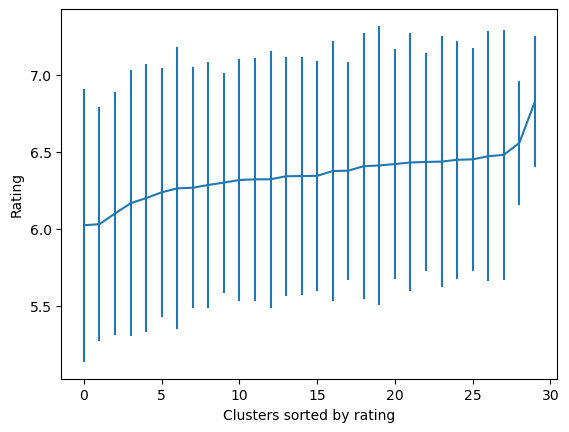

In [85]:
plt.errorbar(data = cluster_ratings_avg_std, x = cluster_ratings_avg_std.index, y = 'Rating_avg', yerr = 'Rating_std')
plt.xlabel("Clusters sorted by rating")
plt.ylabel("Rating")

Looking at this plot with all the clusters sorted by rating and the standard error of mean as error bars, we see that there is a difference in the rating for the 30 clusters, but it looks as if it is not significant. 

We need to find a method that can help us argue choosing a given k, and reevaluate the results. 